In [1]:
!pip install -q -U pip
!pip install -q -U omegaconf 
!pip install -q -U torchsummary

In [2]:
import os
import time
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import model_selection, metrics
import torch
from torch import nn
from omegaconf import OmegaConf, DictConfig
from torchsummary import summary

In [3]:
DICT_CFG = {
    "seed": 42,
    "data": {
        "image_size": 128,
    },
    "train": {
        "batch_size": 128,
        "n_epochs": 10,
    },
    "optimizer": {
        "name": "adam",
        "params": {
            "lr": 0.001,
        },
    },
    "criterion": {
        "name": "bce",
    },
}

CFG = OmegaConf.create(DICT_CFG)
print(OmegaConf.to_yaml(CFG))

seed: 42
data:
  image_size: 128
train:
  batch_size: 128
  n_epochs: 10
optimizer:
  name: adam
  params:
    lr: 0.001
criterion:
  name: bce



In [4]:
def set_seed(seed):
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

In [5]:
class DataExtractor(torch.utils.data.Dataset):    
    def __init__(self, *, ids: list, targets: list, transforms: A.Compose):
        self.ids = ids
        self.targets = targets
        
        self.transforms = transforms
         
    def __len__(self) -> int:
        return len(self.ids)
   
    def __getitem__(self, index: int):
        _id = self.ids[index]
        image_name = f"../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-{_id}.png"
        image = cv2.imread(image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image=image)["image"]

        y = torch.tensor(self.targets[index], dtype=torch.float)

        return {"X": image, "y": y, "path": image_name}

    
def get_train_transforms(image_size: int) -> A.Compose:
    return A.Compose(
        [
            A.LongestMaxSize(p=1.0, max_size=image_size),
            A.RandomBrightnessContrast(
                p=0.5,
                brightness_limit=(-0.2, 0.2),
                contrast_limit=(-0.2, 0.2),
                brightness_by_max=True,
            ),
            A.Blur(p=0.5, blur_limit=(3, 5)),
            A.ShiftScaleRotate(
                p=0.5, shift_limit=(-0.2, 0.2), scale_limit=(-0.5, 0.2), 
                rotate_limit=(-30, 30), interpolation=0, border_mode=0, 
                value=(0, 0, 0), mask_value=None,
            ),
            A.HorizontalFlip(p=0.5),
            A.Normalize(p=1.0),
            A.PadIfNeeded(
                p=1.0,
                min_height=image_size,
                min_width=image_size,
                border_mode=0,
            ),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
    )


def get_valid_transforms(image_size: int) -> A.Compose:
    return A.Compose(
        [
            A.LongestMaxSize(p=1.0, max_size=image_size),
            A.Normalize(p=1.0),
            A.PadIfNeeded(
                p=1.0,
                min_height=image_size,
                min_width=image_size,
                border_mode=0,
            ),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
    )


def denormalize_image(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0):
    return (max_pixel_value * (image * std + mean)).astype(int)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()   
        self.features = nn.Sequential(
            self.make_block(3, 8, kernel_size=3),
            self.make_block(8, 16, kernel_size=3),
            self.make_block(16, 32, kernel_size=3),
            self.make_block(32, 64, kernel_size=3),
            self.make_block(64, 128, kernel_size=3),
        )       
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(128, 1),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def make_block(self, input_channels, output_channels, kernel_size=3, stride=1, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

In [7]:
device = "cpu"

model = Model().to(device) 

summary(model, (3, 128, 128), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
         LeakyReLU-3          [-1, 8, 128, 128]               0
         MaxPool2d-4            [-1, 8, 64, 64]               0
            Conv2d-5           [-1, 16, 64, 64]           1,168
       BatchNorm2d-6           [-1, 16, 64, 64]              32
         LeakyReLU-7           [-1, 16, 64, 64]               0
         MaxPool2d-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           4,640
      BatchNorm2d-10           [-1, 32, 32, 32]              64
        LeakyReLU-11           [-1, 32, 32, 32]               0
        MaxPool2d-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,496
      BatchNorm2d-14           [-1, 64,

In [8]:
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg
        
        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.astype(int)
        y_pred = y_pred >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg
        

class F1Meter:
    def __init__(self):
        self.y_true = []
        self.y_pred = []
        
        self.avg = 0

    def update(self, y_true, y_pred):
        y_pred = y_pred >= 0
        
        self.y_true.extend(y_true)
        self.y_pred.extend(y_pred)
        
        self.avg = metrics.f1_score(self.y_true, self.y_pred)

In [9]:
class Trainer:
    def __init__(self, *, model, device: torch.device, cfg: DictConfig):
        self.device = device
        self.model = model.to(device)
        self.cfg = cfg

        self.init_criterion()
        self.init_optimizer()

        self.epoch = 0
        self.best_summary_loss = 10 ** 9

        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            factor=0.5,
            patience=1,
            threshold_mode="abs",
        )

    def init_criterion(self):
        params = self.cfg.criterion.get("params", {})
        name = self.cfg.criterion.name
        if name == "bce":
            self.criterion = torch.nn.BCEWithLogitsLoss(**params)
        elif name == "bce_weighted":
            self.criterion = torch.nn.BCEWithLogitsLoss(**params)
        elif name == "mae":
            self.criterion = torch.nn.L1Loss(**params)
        else:
            raise ValueError("The criterion name is incorrect.")

    def init_optimizer(self):
        params = self.cfg.optimizer.get("params", {})
        name = self.cfg.optimizer.name
        if name == "adam":
            self.optimizer = torch.optim.Adam(self.model.parameters(), **params)
        else:
            raise ValueError("The optimizer name is incorrect.")

    def fit(self, *, train_extractor: DataExtractor, valid_extractor: DataExtractor) -> None:
        train_loader = torch.utils.data.DataLoader(
            train_extractor,
            batch_size=CFG.train.batch_size,
            shuffle=True,
            num_workers=2,
        )

        valid_loader = torch.utils.data.DataLoader(
            valid_extractor, 
            batch_size=CFG.train.batch_size,
            shuffle=False,
            num_workers=2,
        )

        for e in range(self.cfg.train.n_epochs):
            lr = self.optimizer.param_groups[0]["lr"]
            print(f"EPOCH: {e} LR: {lr}")

            t = time.time()
            train_loss, train_acc, train_f1 = self.train_one_epoch(train_loader)
            print(f"Train. Epoch: {self.epoch}, loss: {train_loss.avg:.5f}, acc: {train_acc.avg:.5f}, f1: {train_f1.avg:.5f}, time: {(time.time() - t):.5f}")

            t = time.time()
            valid_loss, valid_acc, valid_f1 = self.valid_one_epoch(valid_loader)
            print(f"Valid. Epoch: {self.epoch}, loss: {valid_loss.avg:.5f}, acc {valid_acc.avg:.5f}, f1: {valid_f1.avg:.5f}, time: {(time.time() - t):.5f}")

            if valid_loss.avg < self.best_summary_loss:
                self.best_summary_loss = valid_loss.avg
                self.model.eval()
                self.save(f"best_checkpoint.pt")
                print(f"New best model: {self.epoch} epoch.")

            self.scheduler.step(metrics=valid_loss.avg)

            self.epoch += 1

    def valid_one_epoch(self, val_loader):
        self.model.eval()
        loss_meter = LossMeter()
        acc_meter = AccMeter()
        f1_meter = F1Meter()

        for step, batch in enumerate(val_loader):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                y = batch["y"].to(self.device)

                y_pred = self.model(X).squeeze(1)
                loss = self.criterion(y_pred, y)

                loss_meter.update(loss.detach().cpu().item())
                acc_meter.update(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
                f1_meter.update(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())

        return loss_meter, acc_meter, f1_meter

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_meter = LossMeter()
        acc_meter = AccMeter()
        f1_meter = F1Meter()

        for step, batch in enumerate(train_loader):
            X = batch["X"].to(self.device)
            y = batch["y"].to(self.device)

            self.optimizer.zero_grad()
            y_pred = self.model(X).squeeze(1)
            loss = self.criterion(y_pred, y)
            loss.backward()
            
            loss_meter.update(loss.detach().cpu().item())
            acc_meter.update(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
            f1_meter.update(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
            
            self.optimizer.step()

        return loss_meter, acc_meter, f1_meter

    def save(self, path: str) -> None:
        self.model.eval()
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "best_summary_loss": self.best_summary_loss,
                "epoch": self.epoch,
            },
            path,
        )

In [10]:
df = pd.read_csv("../input/glasses-or-no-glasses/train.csv")[["id", "glasses"]]
df.head(2)

,id,glasses
0,1,0
1,2,1


In [11]:
set_seed(CFG.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model()

df_train, df_test = model_selection.train_test_split(
    df, test_size=0.1, random_state=CFG.data.image_size, shuffle=True, stratify=df["glasses"]
)
df_train, df_valid = model_selection.train_test_split(
    df_train, test_size=0.2, random_state=CFG.data.image_size, shuffle=True, stratify=df_train["glasses"]
)
print(df_train["glasses"].value_counts())
print(df_valid["glasses"].value_counts())

train_extractor = DataExtractor(
    ids=df_train["id"].tolist(),
    targets=df_train["glasses"].tolist(),
    transforms=get_train_transforms(CFG.data.image_size)
)
valid_extractor = DataExtractor(
    ids=df_valid["id"].tolist(),
    targets=df_valid["glasses"].tolist(),
    transforms=get_valid_transforms(CFG.data.image_size)
)

1    2056
0    1184
Name: glasses, dtype: int64
1    514
0    296
Name: glasses, dtype: int64


In [12]:
trainer = Trainer(cfg=CFG, model=model, device=device)
trainer.fit(train_extractor=train_extractor, valid_extractor=valid_extractor)

EPOCH: 0 LR: 0.001
Train. Epoch: 0, loss: 0.63814, acc: 0.62840, f1: 0.75862, time: 110.79330
Valid. Epoch: 0, loss: 0.61389, acc 0.71481, f1: 0.76259, time: 28.30342
New best model: 0 epoch.
EPOCH: 1 LR: 0.001
Train. Epoch: 1, loss: 0.58586, acc: 0.67377, f1: 0.77827, time: 100.82074
Valid. Epoch: 1, loss: 0.52039, acc 0.78025, f1: 0.80778, time: 25.44237
New best model: 1 epoch.
EPOCH: 2 LR: 0.001
Train. Epoch: 2, loss: 0.52363, acc: 0.73056, f1: 0.79991, time: 101.68308
Valid. Epoch: 2, loss: 0.43728, acc 0.80617, f1: 0.82953, time: 25.84614
New best model: 2 epoch.
EPOCH: 3 LR: 0.001
Train. Epoch: 3, loss: 0.48115, acc: 0.77037, f1: 0.82527, time: 102.13898
Valid. Epoch: 3, loss: 0.40954, acc 0.84074, f1: 0.86114, time: 25.66906
New best model: 3 epoch.
EPOCH: 4 LR: 0.001
Train. Epoch: 4, loss: 0.43664, acc: 0.78673, f1: 0.83707, time: 101.42153
Valid. Epoch: 4, loss: 0.47673, acc 0.75926, f1: 0.83572, time: 25.78360
EPOCH: 5 LR: 0.001
Train. Epoch: 5, loss: 0.41103, acc: 0.80463, 

In [13]:
model = Model()
model.load_state_dict(torch.load("best_checkpoint.pt")["model_state_dict"])
model = model.to(device)
model = model.eval()

In [14]:
test_extractor = DataExtractor(
    ids=df_test["id"].tolist(),
    targets=df_test["glasses"].tolist(),
    transforms=get_valid_transforms(CFG.data.image_size)
)

test_loader = torch.utils.data.DataLoader(
    test_extractor, 
    batch_size=CFG.train.batch_size,
    shuffle=False,
    num_workers=2,
)

In [15]:
y_preds = []
y_trues = []
paths = []

with torch.no_grad():
    for batch in test_loader:
        X = batch["X"].to(device)
        y = batch["y"]
        path = batch["path"]
        
        y_pred = model(X).squeeze(1)
        y_preds.extend(y_pred.detach().cpu().numpy())
        y_trues.extend(y.numpy())
        paths.extend(path)

In [16]:
y_probs = torch.sigmoid(torch.Tensor(y_preds)).numpy()
y_preds = (y_probs >= 0.5).astype(int)
y_trues = np.array(y_trues)
paths = np.array(paths)

In [17]:
print(f"Test accuracy: {(y_preds == y_trues).sum() / y_preds.shape[0]:.5f}")

Test accuracy: 0.88444


In [18]:
false_probs = y_probs[y_preds != y_trues]
false_reals = y_trues[y_preds != y_trues]
false_paths = paths[y_preds != y_trues]
len(false_paths)

52

../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1167.png


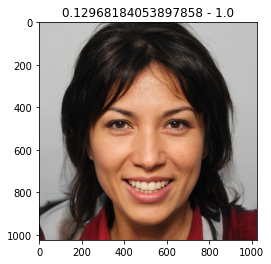

../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1159.png


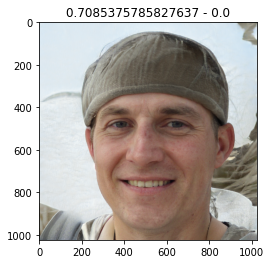

../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2820.png


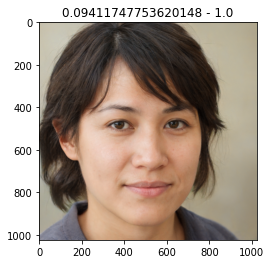

../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3005.png


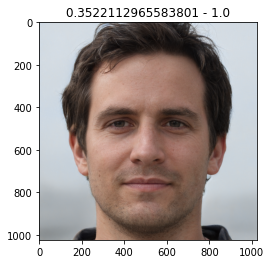

../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2696.png


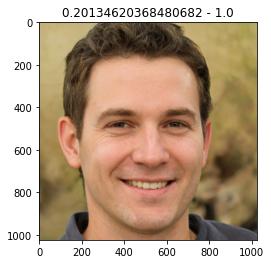

In [19]:
# We have some bad labels...

for path, prob, real in zip(false_paths[:5], false_probs[:5], false_reals[:5]):
    print(path)
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    plt.title(f"{prob} - {real}")
    plt.show()

In [20]:
!pip install -q -U grad-cam==1.3.1
!pip install -q -U ttach

In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [22]:
transforms = get_valid_transforms(CFG.data.image_size)

In [23]:
target_layer = model.features[-1]
cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)

In [24]:
!nvidia-smi

Sun Oct 31 21:50:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    35W / 250W |   1563MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Prediction time: 0.005800008773803711, result: [0.9765351]


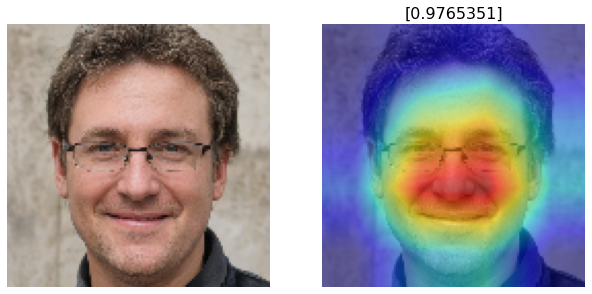

Prediction time: 0.0023207664489746094, result: [0.9985936]


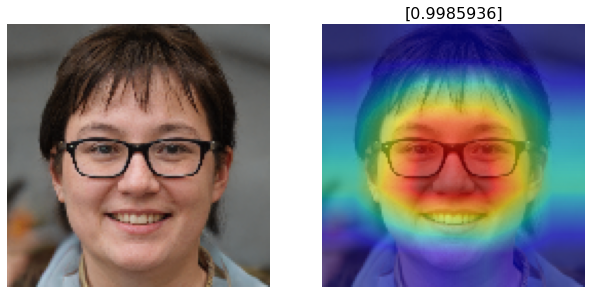

Prediction time: 0.002499818801879883, result: [0.99920183]


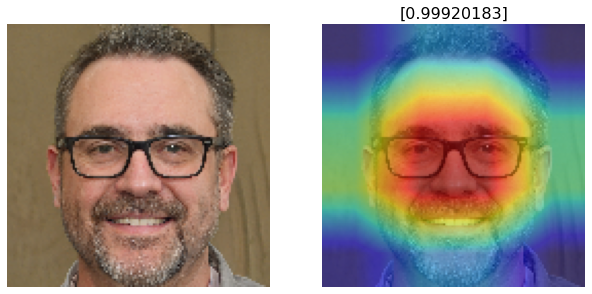

Prediction time: 0.0021660327911376953, result: [0.0892225]


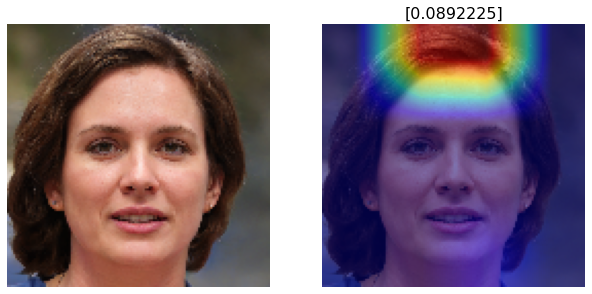

Prediction time: 0.002201557159423828, result: [0.9958028]


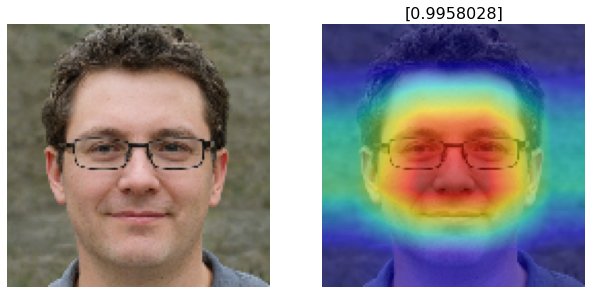

Prediction time: 0.0021054744720458984, result: [0.994795]


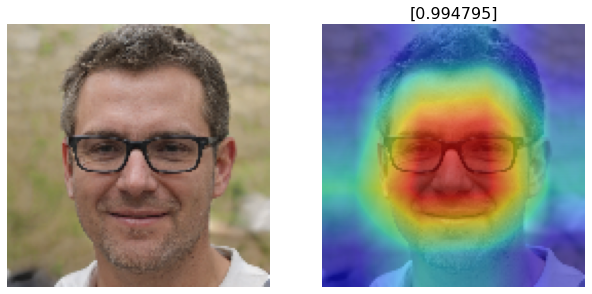

Prediction time: 0.0020580291748046875, result: [0.98848397]


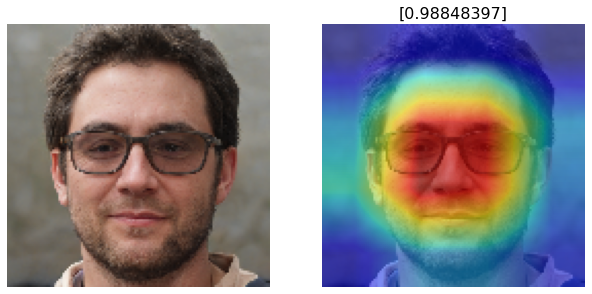

Prediction time: 0.0022957324981689453, result: [0.9962618]


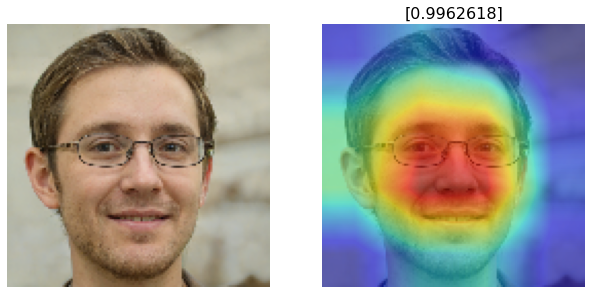

Prediction time: 0.0021195411682128906, result: [0.35226962]


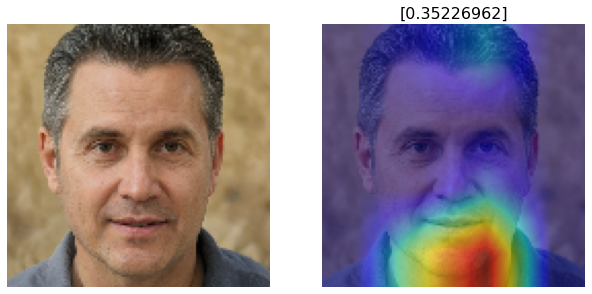

Prediction time: 0.0022051334381103516, result: [0.9933082]


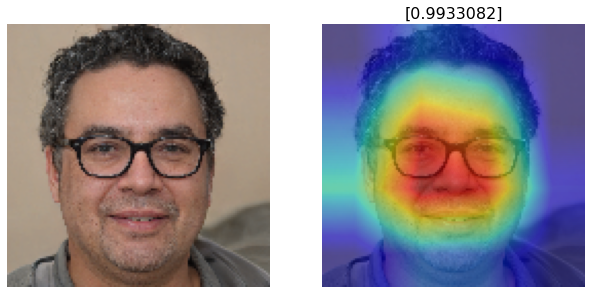

In [25]:
paths = [f"../input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-{i}.png" for i in df_test["id"].tolist()[:10]]

for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed_image = transforms(image=image)["image"].unsqueeze(dim=0)
    default_image = denormalize_image(transformed_image[0].numpy().transpose(1, 2, 0))

    with torch.no_grad():
        t = time.time()
        tmp = torch.sigmoid(model(transformed_image.to(device)).cpu()).numpy()[0]
        print(f"Prediction time: {time.time() - t}, result: {tmp}")

    plt.figure(figsize=(16, 24))
    plt.subplot(4, 3, 1)
    plt.imshow(default_image)
    plt.axis("off")
    
    
    plt.subplot(4, 3, 2)
    grayscale_cam = cam(input_tensor=transformed_image)[0, :]

    plt.imshow(default_image)
    plt.imshow(grayscale_cam, cmap="jet", alpha=0.5)
    plt.title(f"{tmp}", fontsize=16)
    plt.axis("off")

    plt.show()